# NLP - Sentiment analysis using CF

IMDB Dataset
- 25000 reviews each has label 1=positive, 0 = negative
- Each review is a variable lenght int vector, where each int corresponds to id of a word
- Words are arranged based on their frequency. That is word at index 0 is most frequently occuring word.

Simplied dataset:
- Reduce corpus to most frequent words - 5000 words
    Q: All infrequent words replaced with word at 4999? Why is this simplification useful? 
- Make the word vector of each review fixed length. Why?
    Truncate each review to 500 words: Pad for small ones
- Simplified dataset: 25000 x 500

Bench mark:
- Stanford 88.33 acc


In [2]:
from theano.sandbox import cuda
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [4]:
import sys
sys.path.append('../PreTrainedModels')
import vgg16bn; reload(vgg16bn)
from vgg16bn import Vgg16BN

In [6]:
import sys
sys.path.append('../utilities')
import utils; reload(utils)
from utils import *

In [9]:
model_path = 'data/imdb/models/'

## Get data and explore

In [11]:
from keras.datasets import imdb
idx = imdb.get_word_index()

In [52]:
idx2word = {v: k for k, v in idx.iteritems()}

In [139]:
(trn, trn_labels),(val, val_labels) = imdb.load_data()

In [140]:
type(trn), type(trn_labels)

(numpy.ndarray, numpy.ndarray)

### Truncate vocabulary to 5000

In [9]:
vocab_size = 5000

In [141]:
trn = [np.array([i if i<vocab_size-1 else 0 for i in s]) for s in trn]
val = [np.array([i if i<vocab_size-1 else 0 for i in s]) for s in val]

In [142]:
type(trn), type(trn_labels)

(list, numpy.ndarray)

In [78]:
#Size of training data
len(trn), len(trn_labels)

(25000, 25000)

In [21]:
#Size of validation data
len(val), len(val_labels)

(25000, 25000)

In [60]:
#Size of corpus
len(idx)

88584

In [79]:
trn_lens = np.array([len(x) for x in trn])
val_lens = np.array([len(x) for x in val])

In [82]:
(trn_lens.max(), trn_lens.min(), trn_lens.mean(), np.median(trn_lens))

(2494, 11, 238.71364, 178.0)

In [85]:
(val_lens.max(), val_lens.min(), val_lens.mean(), np.median(val_lens))

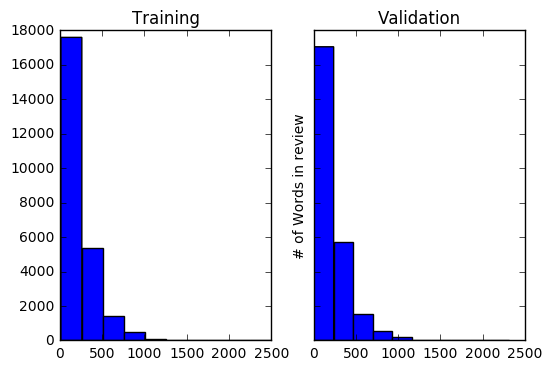

In [250]:
f, axarr = plt.subplots(ncols=2, sharey=True)
axarr[0].hist(trn_lens)
axarr[0].set_title('Training')
axarr[1].hist(val_lens)
axarr[1].set_title('Validation')
plt.ylabel('# of Words in review')
plt.show()

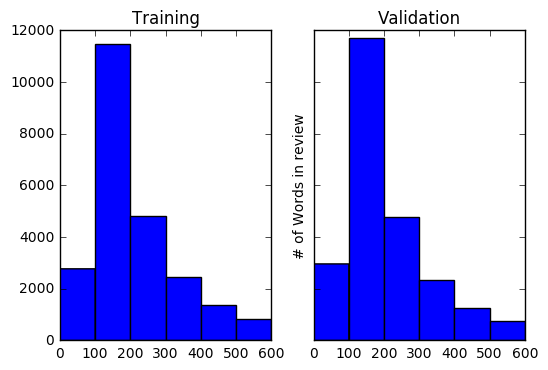

In [251]:
f, axarr = plt.subplots(ncols=2, sharey=True)
axarr[0].hist(trn_lens, bins=[0, 100, 200, 300, 400, 500, 600])
axarr[0].set_title('Training')
axarr[1].hist(val_lens, bins=[0, 100, 200, 300, 400, 500, 600])
axarr[1].set_title('Validation')
plt.ylabel('# of Words in review')
plt.show()

### Train and test have very similar distributions. And seems like 500 is a good length

In [143]:
seq_len = 500
trn = sequence.pad_sequences(trn, maxlen=seq_len, value=0)
val = sequence.pad_sequences(val, maxlen=seq_len, value=0)

In [252]:
trn.shape, val.shape

((25000, 500), (25000, 500))

In [253]:
trn.max(), val.max()

(4998, 4998)

### Truncate less frequent words so that our embedding is not too big

## Simple model, Emb + Flatten + D + DO + D(sigmoid)
Note:
    - Input: Review containing 500 words, output: 1/0 (positive/negative)
    - Input layer = Embedding: IP = 500, OP = 500x32


In [7]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])

NameError: name 'vocab_size' is not defined

In [101]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 500, 32)       160000      embedding_input_1[0][0]          
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 16000)         0           embedding_1[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 100)           1600100     flatten_1[0][0]                  
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 100)           0           dense_1[0][0]                    
___________________________________________________________________________________________

In [148]:
type(trn), type(trn_labels)

(numpy.ndarray, numpy.ndarray)

In [132]:
#Create ndarrays to pass to model.fit
#trn= np.array(trn)
#val= np.array(val)

In [149]:
model.fit(trn, trn_labels, validation_data=(val, val_labels), nb_epoch=2, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 4s - loss: 0.0812 - acc: 0.9737 - val_loss: 0.3880 - val_acc: 0.8678
Epoch 2/2
25000/25000 [==============================] - 3s - loss: 0.0277 - acc: 0.9925 - val_loss: 0.4673 - val_acc: 0.8640


In [11]:
seq_len=500

In [12]:
conv1 = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len, dropout=0.2),
    Dropout(0.2),
    Convolution1D(64, 5, border_mode='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])

In [13]:
conv1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 500, 32)       160000      embedding_input_1[0][0]          
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 500, 32)       0           embedding_1[0][0]                
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 500, 64)       10304       dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 500, 64)       0           convolution1d_1[0][0]            
___________________________________________________________________________________________

In [151]:
conv1.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [152]:
conv1.fit(trn, trn_labels, validation_data=(val, val_labels), nb_epoch=4, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 12s - loss: 0.4979 - acc: 0.7381 - val_loss: 0.3074 - val_acc: 0.8732
Epoch 2/4
25000/25000 [==============================] - 11s - loss: 0.3100 - acc: 0.8752 - val_loss: 0.2886 - val_acc: 0.8789
Epoch 3/4
25000/25000 [==============================] - 11s - loss: 0.2715 - acc: 0.8931 - val_loss: 0.2677 - val_acc: 0.8890
Epoch 4/4
25000/25000 [==============================] - 11s - loss: 0.2420 - acc: 0.9024 - val_loss: 0.2670 - val_acc: 0.8894


## Use Pretrained embeddings with CNN

In [153]:
GLOVE_DIR='../PreTrainedModels/glove/'

In [163]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [164]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [165]:
len(embeddings_index.get('the'))

50

In [228]:
### Create embeddings by adjusting the imdb word ids to glove word ids
# For each id in imdb word vector
    # Get the word for that id 
    # Get embedding for that word from glove
    # If not exist, setup 0s.

def create_emb():
    n_fact = 50
    success=0
    not_found=0
    emb = np.zeros((vocab_size, n_fact))
    for i in range(1,len(emb)):
        word = idx2word[i]
        if word and re.match(r"^[a-zA-Z0-9\-]*$", word):
            #src_idx = wordidx[word]
            #emb[i] = vecs[src_idx]
            emb[i] = embeddings_index.get(word)
            success += 1
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))
            not_found += 1

    # This is our "none word" id - we want to randomly initialize
    emb[0] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    print (success, not_found)
    return emb

In [229]:
emb = create_emb()

(4914, 85)


In [230]:
nones = [i for i in emb if i is not None]

In [231]:
len(nones)

5000

In [1]:
model = Sequential([
    Embedding(vocab_size, 50, input_length=seq_len, dropout=0.2, 
              weights=[emb], trainable=False),
    Dropout(0.25),
    Convolution1D(64, 5, border_mode='same', activation='relu'),
    Dropout(0.25),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')])

NameError: name 'Sequential' is not defined

In [235]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [236]:
model.fit(trn, trn_labels, validation_data=(val, val_labels), nb_epoch=2, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 11s - loss: 0.6938 - acc: 0.5189 - val_loss: 0.6875 - val_acc: 0.5404
Epoch 2/2
25000/25000 [==============================] - 10s - loss: 0.6820 - acc: 0.5535 - val_loss: 0.6767 - val_acc: 0.5554


In [209]:
model.layers[0].trainable=True

In [210]:
model.optimizer.lr=1e-4

In [211]:
model.fit(trn, trn_labels, validation_data=(val, val_labels), nb_epoch=2, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 13s - loss: 0.2992 - acc: 0.8761 - val_loss: 0.3036 - val_acc: 0.8765
Epoch 2/2
25000/25000 [==============================] - 13s - loss: 0.2654 - acc: 0.8927 - val_loss: 0.2947 - val_acc: 0.8790


In [212]:
model.optimizer.lr=1e-5

In [213]:
model.fit(trn, trn_labels, validation_data=(val, val_labels), nb_epoch=2, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 13s - loss: 0.2441 - acc: 0.9006 - val_loss: 0.3185 - val_acc: 0.8599
Epoch 2/2
25000/25000 [==============================] - 13s - loss: 0.2259 - acc: 0.9092 - val_loss: 0.2786 - val_acc: 0.8847


## Multi-CNNS

In [255]:
from keras.layers import Merge

In [256]:
graph_in = Input ((vocab_size, 50))
convs = [ ] 
for fsz in range (3, 6): 
    x = Convolution1D(64, fsz, border_mode='same', activation="relu")(graph_in)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)
out = Merge(mode="concat")(convs) 
graph = Model(graph_in, out) 

In [257]:
emb = create_emb()

(4914, 85)


In [258]:
model = Sequential ([
    Embedding(vocab_size, 50, input_length=seq_len, dropout=0.2, weights=[emb]),
    Dropout (0.2),
    graph,
    Dropout (0.5),
    Dense (100, activation="relu"),
    Dropout (0.7),
    Dense (1, activation='sigmoid')
    ])

In [259]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [260]:
model.fit(trn, trn_labels, validation_data=(val, val_labels), nb_epoch=2, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 30s - loss: 0.6565 - acc: 0.5760 - val_loss: 0.4454 - val_acc: 0.7883
Epoch 2/2
25000/25000 [==============================] - 29s - loss: 0.3771 - acc: 0.8396 - val_loss: 0.2966 - val_acc: 0.8803


In [261]:
model.layers[0].trainable=False

In [262]:
model.optimizer.lr=1e-5

In [263]:
model.fit(trn, trn_labels, validation_data=(val, val_labels), nb_epoch=2, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 30s - loss: 0.3000 - acc: 0.8790 - val_loss: 0.2886 - val_acc: 0.8794
Epoch 2/2
25000/25000 [==============================] - 30s - loss: 0.2703 - acc: 0.8924 - val_loss: 0.2624 - val_acc: 0.8934


## LSTM

In [264]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len, mask_zero=True,
              W_regularizer=l2(1e-6), dropout=0.2),
    LSTM(100, consume_less='gpu'),
    Dense(1, activation='sigmoid')])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_8 (Embedding)          (None, 500, 32)       160000      embedding_input_8[0][0]          
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 100)           53200       embedding_8[0][0]                
____________________________________________________________________________________________________
dense_15 (Dense)                 (None, 1)             101         lstm_1[0][0]                     
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
____________________________________________________________________________________________________


In [ ]:
model.fit(trn, trn_labels, validation_data=(val, val_labels), nb_epoch=8, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/8
16384/25000 [==================>...........] - ETA: 52s - loss: 0.5356 - acc: 0.7223